In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from comet_ml import Experiment
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt 

import seaborn as sns
import probscale
import matplotlib.ticker as mtick

from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve
import matplotlib.transforms as mtransforms
from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

import shap

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.dummy import DummyClassifier








In [2]:
os.environ['COMET_API_KEY'] = 'c2REbE8eQaoRTP059ajV8VYn9'


In [3]:
COMET_API_KEY = os.environ.get("COMET_API_KEY")

In [4]:
experiment_1 = Experiment(
    api_key=COMET_API_KEY,
    project_name="ift-6758",
    workspace="ift-6758-2",
)
experiment_1.set_name('Question-5/XGB-Distance+Angle')


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift-6758-2/ift-6758/470b9f71fe0a46ff80cf3a8e54cff282



In [5]:
def metrics(experiment, model, x_test, y_test, model_name, features_name):
    '''
    calculate and log the metrics like: accuracy score for validation
    dataset, confusion matrix, ROC AUC score, ROC curve.
    '''
    pred = model.predict(x_test)
    acc_ex = accuracy_score(y_test,pred)
    experiment.log_metric(f"validation accuracy {model_name}-{features_name}", acc_ex)
    experiment.log_confusion_matrix(y_test,pred)
    print(f"Validation Accuracy: {acc_ex}")
    prob_predicted = model.predict_proba(x_test)
    lr_probs = prob_predicted[:,1]
    lr_auc = np.round((roc_auc_score(y_test, lr_probs)),4)
    print(f"ROC AUC:{lr_auc}")
    experiment.log_metric(f"AUC Score {model}- {features_name} ", lr_auc)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    experiment.log_curve(f"roc-curve-class-{model}-{features_name}",lr_fpr, lr_tpr)
    experiment.end()


    return acc_ex, lr_auc, lr_fpr, lr_tpr, lr_probs



    

### 5.1

In [6]:
train_data = pd.read_csv("train_2015_2018.csv", index_col=None)
test_data = pd.read_csv("test_2019.csv", index_col=None)

In [7]:
train_data.head()

,Unnamed: 0,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,...,number_friendly,number_opposing,power_play,distance,from_last_distance,angle,last_angle,time_from_last,change_angle,speed
0,0,7,00:51,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-55.0,6.0,...,5,5,0,34.5254,154.275727,0.1747,1.4248,51,0.0000,0.000000
1,1,9,01:05,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-79.0,0.0,...,5,5,0,10.0000,50.477718,0.0000,0.4939,65,0.0000,0.000000
2,2,10,01:06,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-75.0,-1.0,...,5,5,0,14.0357,4.123106,0.0713,0.0000,6,0.0713,0.687184
3,3,13,01:53,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-55.0,-36.0,...,5,5,0,49.5177,79.605276,0.8140,1.5137,53,0.0000,0.000000
4,4,21,02:37,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-61.0,-1.0,...,5,5,0,28.0179,22.472205,0.0357,0.8330,37,0.0000,0.000000


In [8]:
goal_data = train_data[['distance','angle','is_goal']]
goal_data

,distance,angle,is_goal
0,34.5254,0.1747,0
1,10.0000,0.0000,0
2,14.0357,0.0713,0
3,49.5177,0.8140,0
4,28.0179,0.0357,0
...,...,...,...
332737,13.8924,0.5281,1
332738,21.1896,0.3367,0
332739,24.3311,0.1651,0
332740,47.0956,0.0637,0


In [9]:
X = np.array(goal_data[['distance','angle']])
Y = np.array(goal_data[['is_goal']])

In [10]:
rng = np.random.RandomState(0)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=rng, shuffle=True)

In [12]:
model_first = XGBClassifier()
model_first.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [13]:
acc_ex_first, lr_auc_first, lr_fpr_first, lr_tpr_first, lr_probs_first = metrics(experiment_1, model_first, X_test, y_test, "XGB", "Distance+Angle")

COMET WARNING: truncated string; too long: 'AUC Score XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)- Distance+Angle '...
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : http

Validation Accuracy: 0.9066852995537124
ROC AUC:0.7091


COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


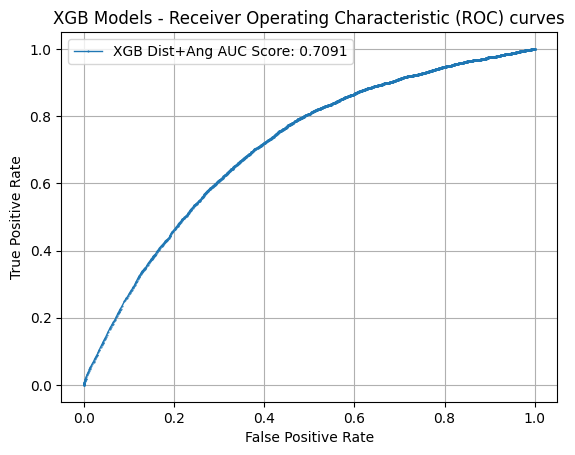

In [14]:
#ROC PLOT
plt.plot(lr_fpr_first, lr_tpr_first, marker='.', linewidth=1, markersize=1,label=f"XGB Dist+Ang AUC Score: {lr_auc_first}")
plt.title('XGB Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

In [74]:
def plot_gr_perc(lr_probs, y_test):
    df_prob_goals = pd.DataFrame()
    df_prob_goals['y_prob_lr'] = lr_probs
    df_prob_goals['y_test'] = y_test

    d = np.sort(df_prob_goals['y_prob_lr'])
    # Percentile values
    p = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0,100.0])
    perc = np.percentile(d, p)

    x = pd.cut(df_prob_goals[df_prob_goals['y_test'] == 1]['y_prob_lr'], bins=perc, duplicates = 'drop').reset_index()
    x =x.groupby('y_prob_lr', as_index=False).size()
    x.columns = ['y_prob_lr', 'count']

    y = pd.cut(df_prob_goals['y_prob_lr'], bins=perc, duplicates = 'drop').reset_index()
    y =y.groupby('y_prob_lr', as_index=False).size()
    y.columns = ['y_prob_lr', 'count']

    
    return df_prob_goals, x, y

In [20]:
df_prob_goals_first, x_first, y_first = plot_gr_perc(lr_probs_first, y_test)

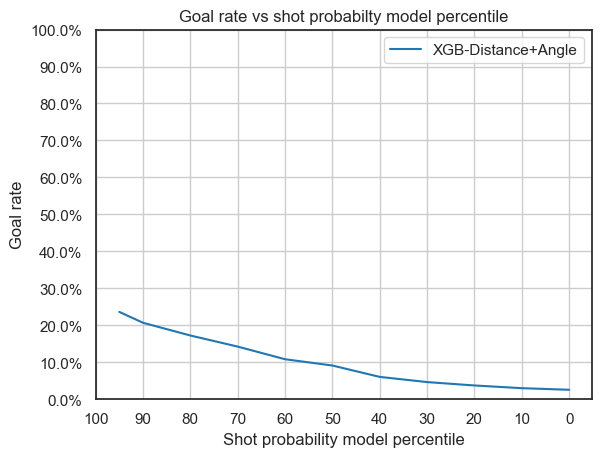

In [23]:

sns.set_theme(style="white", palette=None)
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_first['count'] / y_first['count']), label = 'XGB-Distance+Angle')
plt.title('Goal rate vs shot probabilty model percentile')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Goal rate")
yticks = mtick.FormatStrFormatter('%.1f%%' )
plt.gca().yaxis.set_major_formatter(yticks)
plt.gca().invert_xaxis()
plt.grid()
plt.xticks(np.arange(0, 101, 10.0))
plt.yticks(np.arange(0, 101, 10.0))
plt.show()


In [78]:
def plot_partition_perc(df_prob_goals):
    goals = df_prob_goals[df_prob_goals['y_test']==1]

    d = np.sort(goals['y_prob_lr'])
    # Percentile values
    p = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,100.0])
    perc = np.percentile(d, p)

    x = pd.cut(goals['y_prob_lr'], bins=perc, duplicates = 'drop').reset_index()
    x =x.groupby('y_prob_lr', as_index=False).size()
    x.columns = ['y_prob_lr', 'count']

    z = len(goals['y_test'])

    return x, z

    

In [25]:
x_partition_first, z_first = plot_partition_perc(df_prob_goals_first)

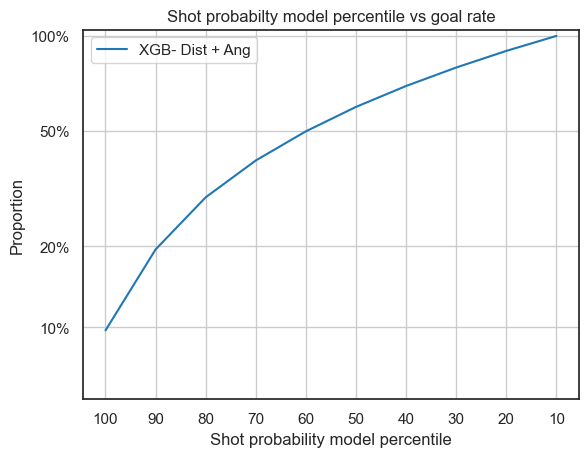

In [26]:
sns.set_theme(style="white", palette=None)
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_first['count']/z_first))).cumsum(), label = 'XGB- Dist + Ang')
plt.title('Shot probabilty model percentile vs goal rate')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Proportion")
plt.yscale('prob')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid()
plt.show()

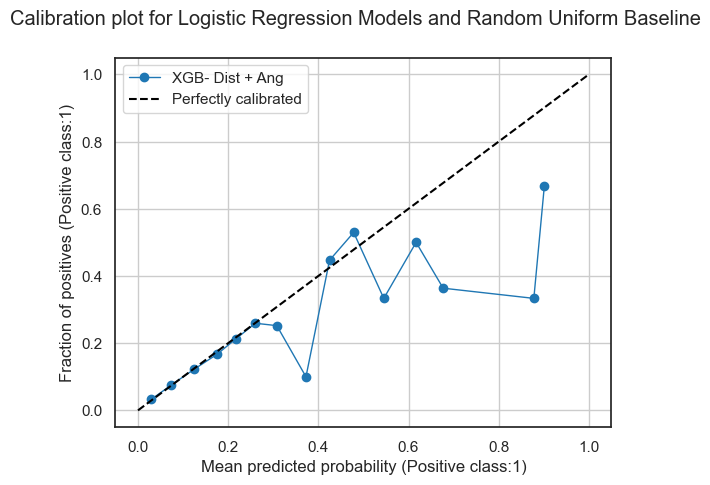

In [27]:
xgb_y, xgb_x = calibration_curve(y_test, lr_probs_first, n_bins=20)
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(xgb_x,xgb_y, marker='o', linewidth=1, label='XGB- Dist + Ang')

# reference line, legends, and axis labels
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
fig.suptitle('Calibration plot for Logistic Regression Models and Random Uniform Baseline')
ax.set_xlabel('Mean predicted probability (Positive class:1)')
ax.set_ylabel('Fraction of positives (Positive class:1)')
plt.grid()
plt.legend()
plt.show()

## 5.2

In [28]:
experiment_2 = Experiment(
    api_key=COMET_API_KEY,
    project_name="ift-6758",
    workspace="ift-6758-2",
)
experiment_2.set_name('Question-5/XGB-AllFeatures')


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift-6758-2/ift-6758/2e3bca4644ae49a5bf1fcb20f5fc685e



In [29]:
feature = ['period', 'coordinate_x', 'coordinate_y', 'shot_type', 'distance', 'angle', 'last_type', 'last_coord_x', 'last_coord_y', 'time_from_last', 'from_last_distance', 'rebound',
 'change_angle', 'speed','power_play', 'number_friendly', 'number_opposing']
 

In [30]:
goal_data_2 = train_data[feature]
goal_data_2

,period,coordinate_x,coordinate_y,shot_type,distance,angle,last_type,last_coord_x,last_coord_y,time_from_last,from_last_distance,rebound,change_angle,speed,power_play,number_friendly,number_opposing
0,1,-55.0,6.0,Wrist Shot,34.5254,0.1747,HIT,94.0,-34.0,51,154.275727,False,0.0000,0.000000,0,5,5
1,1,-79.0,0.0,Snap Shot,10.0000,0.0000,GIVEAWAY,-37.0,-28.0,65,50.477718,False,0.0000,0.000000,0,5,5
2,1,-75.0,-1.0,Snap Shot,14.0357,0.0713,SHOT,-79.0,0.0,6,4.123106,True,0.0713,0.687184,0,5,5
3,1,-55.0,-36.0,Wrist Shot,49.5177,0.8140,HIT,-91.0,35.0,53,79.605276,False,0.0000,0.000000,0,5,5
4,1,-61.0,-1.0,Tip-In,28.0179,0.0357,FACEOFF,-69.0,-22.0,37,22.472205,False,0.0000,0.000000,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332737,3,-77.0,7.0,Snap Shot,13.8924,0.5281,GIVEAWAY,-57.0,34.0,82,33.600595,False,0.0000,0.000000,0,5,5
332738,3,-69.0,7.0,Snap Shot,21.1896,0.3367,HIT,-68.0,-29.0,51,36.013886,False,0.0000,0.000000,0,5,5
332739,3,-65.0,-4.0,Snap Shot,24.3311,0.1651,SHOT,-69.0,7.0,55,11.704700,True,0.1716,0.212813,0,5,5
332740,3,42.0,3.0,Wrist Shot,47.0956,0.0637,STOP,NaN,NaN,50,NaN,False,0.0000,0.000000,0,5,5


In [31]:
goal_data_2.select_dtypes('object').columns

Index(['shot_type', 'last_type'], dtype='object')

In [32]:
le = LabelEncoder()
goal_data_2["shot_type"] = le.fit_transform(goal_data_2["shot_type"])
goal_data_2["last_type"] = le.fit_transform(goal_data_2["last_type"])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
X_2 = goal_data_2
Y_2 = np.array(train_data['is_goal'])

In [34]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, Y_2, test_size=0.2, random_state=rng, shuffle=True)

In [35]:
X_train_2.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_2.fillna(0, inplace=True)

In [84]:
ns_probs = np.random.uniform(low=0.0, high=1.0, size=(len(y_test)))
ns_auc = np.round((roc_auc_score(y_test, ns_probs)),4)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)


In [38]:
model_second = XGBClassifier()
model_second.fit(X_train_2,y_train_2)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [39]:
acc_ex_second, lr_auc_second, lr_fpr_second, lr_tpr_second, lr_probs_second = metrics(experiment_2, model_second, X_test_2, y_test_2, "XGB", "AllFeatures")

COMET WARNING: truncated string; too long: 'AUC Score XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)- AllFeatures '...


Validation Accuracy: 0.9065801139010353
ROC AUC:0.7332


In [40]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}



skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 0)
search_random = RandomizedSearchCV(model_second, param_distributions=params, n_iter=5, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_2,y_train_2), verbose=3, random_state=0 )


search_random.fit(X_train_2,y_train_2)

hp_params = search_random.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100;, score=0.733 total time=  25.5s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100;, score=0.734 total time=  28.4s
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100;, score=0.734 total time=  30.9s
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100;, score=0.741 total time=  16.0s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100;, score=0.742 total time=  17.4s
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100;, score=0.742 total time=  16.5s
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=0.705 total time= 4.5min
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=0.707 total time= 4

In [41]:
hp_params

{'n_estimators': 100,
 'max_depth': 6,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7}

In [42]:
model_2_best = XGBClassifier(**hp_params)
model_2_best.fit(X_train_2, y_train_2)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [43]:
experiment_best = Experiment(
    api_key=COMET_API_KEY,
    project_name="ift-6758",
    workspace="ift-6758-2",
)
experiment_best.set_name('Question-5/XGB-best-AllFeatures')


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift-6758-2/ift-6758/36f0eb7e500949ca9fb56f0e622283de



In [44]:
acc_ex_best, lr_auc_best, lr_fpr_best, lr_tpr_best, lr_probs_best = metrics(experiment_best, model_2_best, X_test_2, y_test_2, "XGB-best", "AllFeatures")

COMET WARNING: truncated string; too long: 'AUC Score XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)- AllFeatures '...


Validation Accuracy: 0.9068205382500113
ROC AUC:0.7414


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift-6758-2/ift-6758/36f0eb7e500949ca9fb56f0e622283de
COMET INFO:   Metrics:
COMET INFO:     AUC Score XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               [truncated] : 0.7414
COMET INFO:     validation accuracy XGB-best-AllFeatures                                                             : 0.9068205382500113
COMET INFO:   Others:
COMET INFO:     Name : Question-5/XGB-best-AllFeatures
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     curve                    : 1
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (549.86 KB)
COMET INFO:     installed packages

In [45]:
hp_param = {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
hp_param_2 = {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.3}
hp_param_3 = {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
hp_param_4 = {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.3}


model1 = XGBClassifier(**hp_param)
model2 = XGBClassifier(**hp_param_2)
model3 = XGBClassifier(**hp_param_3)
model4 = XGBClassifier(**hp_param_4)
               
result1 = model1.fit(X_train_2, y_train_2)
result2 = model2.fit(X_train_2, y_train_2)
result3 = model3.fit(X_train_2, y_train_2)
result4 = model4.fit(X_train_2, y_train_2)

In [46]:
prob1_hp_predicted = model1.predict_proba(X_test_2)
lr1_hp_probs = prob1_hp_predicted[:, 1]
lr1_hp_auc = np.round((roc_auc_score(y_test_2, lr1_hp_probs)),4)
lr1_hp_fpr, lr1_hp_tpr, _ = roc_curve(y_test_2, lr1_hp_probs)

prob2_hp_predicted = model2.predict_proba(X_test_2)
lr2_hp_probs = prob2_hp_predicted[:, 1]
lr2_hp_auc = np.round((roc_auc_score(y_test_2, lr2_hp_probs)),4)
lr2_hp_fpr, lr2_hp_tpr, _ = roc_curve(y_test_2, lr2_hp_probs)

prob3_hp_predicted = model3.predict_proba(X_test_2)
lr3_hp_probs = prob3_hp_predicted[:, 1]
lr3_hp_auc = np.round((roc_auc_score(y_test_2, lr3_hp_probs)),4)
lr3_hp_fpr, lr3_hp_tpr, _ = roc_curve(y_test_2, lr3_hp_probs)

prob4_hp_predicted = model4.predict_proba(X_test_2)
lr4_hp_probs = prob4_hp_predicted[:, 1]
lr4_hp_auc = np.round((roc_auc_score(y_test_2, lr4_hp_probs)),4)
lr4_hp_fpr, lr4_hp_tpr, _ = roc_curve(y_test_2, lr4_hp_probs)


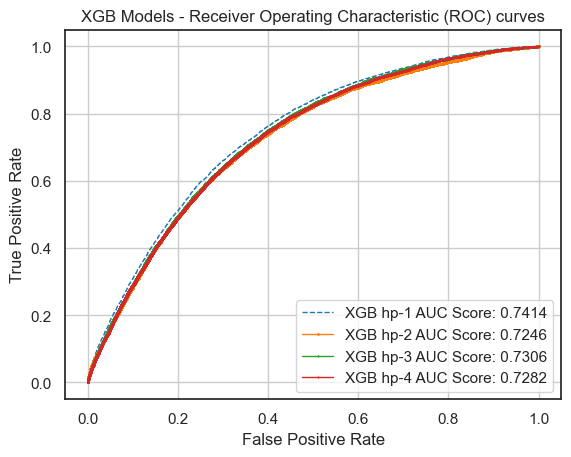

In [47]:
plt.plot(lr1_hp_fpr, lr1_hp_tpr, linestyle='--',linewidth=1, markersize=1, label=f"XGB hp-1 AUC Score: {lr1_hp_auc}")
plt.plot(lr2_hp_fpr, lr2_hp_tpr, marker='o', linewidth=1, markersize=1,label=f"XGB hp-2 AUC Score: {lr2_hp_auc}")
plt.plot(lr3_hp_fpr, lr3_hp_tpr, marker='*', linewidth=1, markersize=1,label=f"XGB hp-3 AUC Score: {lr3_hp_auc}")
plt.plot(lr4_hp_fpr, lr4_hp_tpr, marker='.', linewidth=1, markersize=1,label=f"XGB hp-4 AUC Score: {lr4_hp_auc}")
plt.title('XGB Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

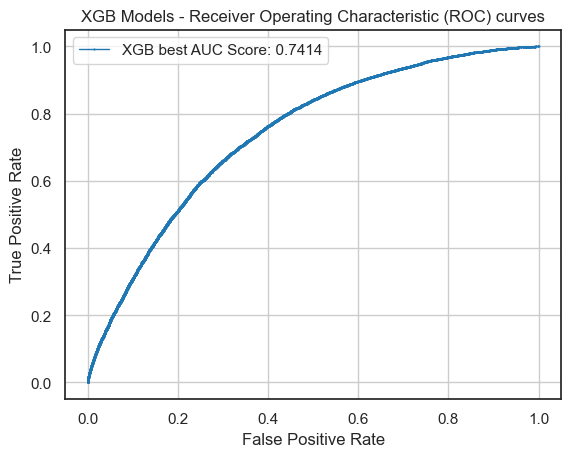

In [48]:
#ROC PLOT
plt.plot(lr_fpr_best, lr_tpr_best, marker='.', linewidth=1, markersize=1,label=f"XGB best AUC Score: {lr_auc_best}")
plt.title('XGB Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

In [49]:
df_prob_goals_second, x_second, y_second = plot_gr_perc(lr_probs_best, y_test_2)

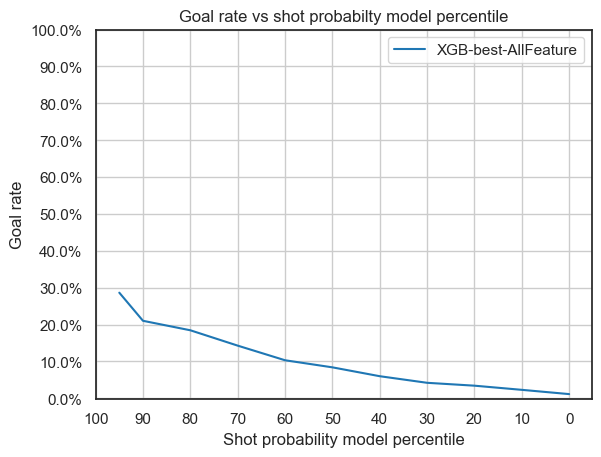

In [52]:
sns.set_theme(style="white", palette=None)
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_second['count'] / y_second['count']), label = f'XGB-best-AllFeature')
plt.title('Goal rate vs shot probabilty model percentile')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Goal rate")
#ax.set_yscale('prob')
fmt = '%.1f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)
plt.gca().invert_xaxis()
plt.grid()
plt.xticks(np.arange(0, 101, 10.0))
plt.yticks(np.arange(0, 101, 10.0))
plt.show()


In [53]:
x_partition_second, z_second = plot_partition_perc(df_prob_goals_second)

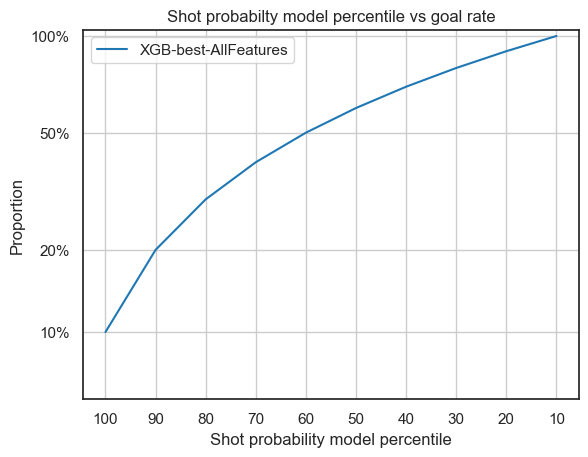

In [54]:
sns.set_theme(style="white", palette=None)
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_second['count']/z_second))).cumsum(), label = 'XGB-best-AllFeatures')
plt.title('Shot probabilty model percentile vs goal rate')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Proportion")
plt.yscale('prob')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid()
plt.show()

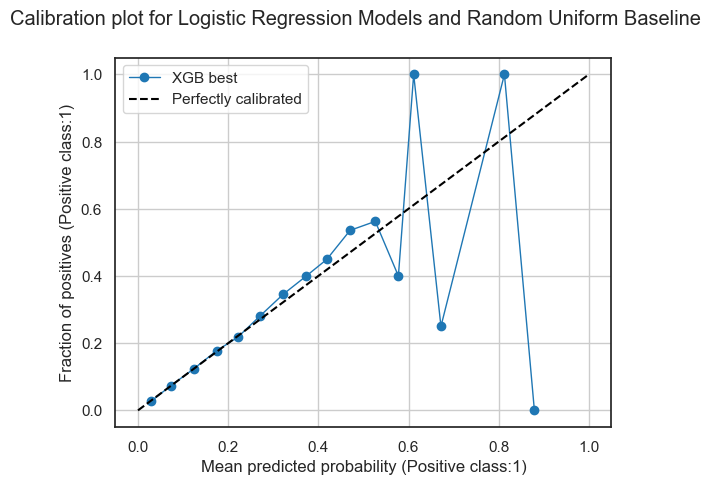

In [55]:
xgb_y, xgb_x = calibration_curve(y_test_2, lr_probs_best, n_bins=20)
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(xgb_x,xgb_y, marker='o', linewidth=1, label='XGB best')

# reference line, legends, and axis labels
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
fig.suptitle('Calibration plot for Logistic Regression Models and Random Uniform Baseline')
ax.set_xlabel('Mean predicted probability (Positive class:1)')
ax.set_ylabel('Fraction of positives (Positive class:1)')
plt.grid()
plt.legend()
plt.show()

## 5.3

In [56]:
experiment_sharp = Experiment(
    api_key=COMET_API_KEY,
    project_name="ift-6758",
    workspace="ift-6758-2",
)
experiment_sharp.set_name('Question-5/XGB-SharpFeatureSelection')


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift-6758-2/ift-6758/01526300a9354b06b8aa552bf0aa72b6



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


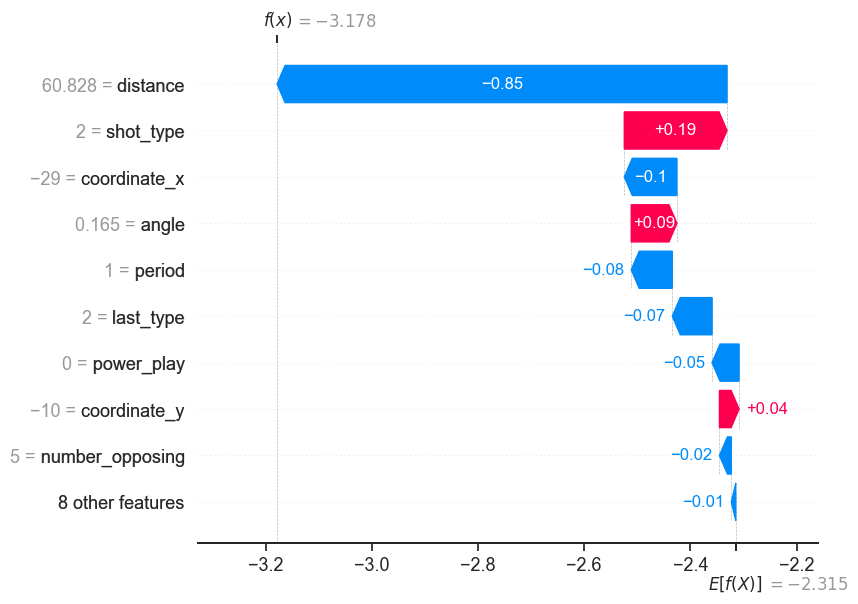

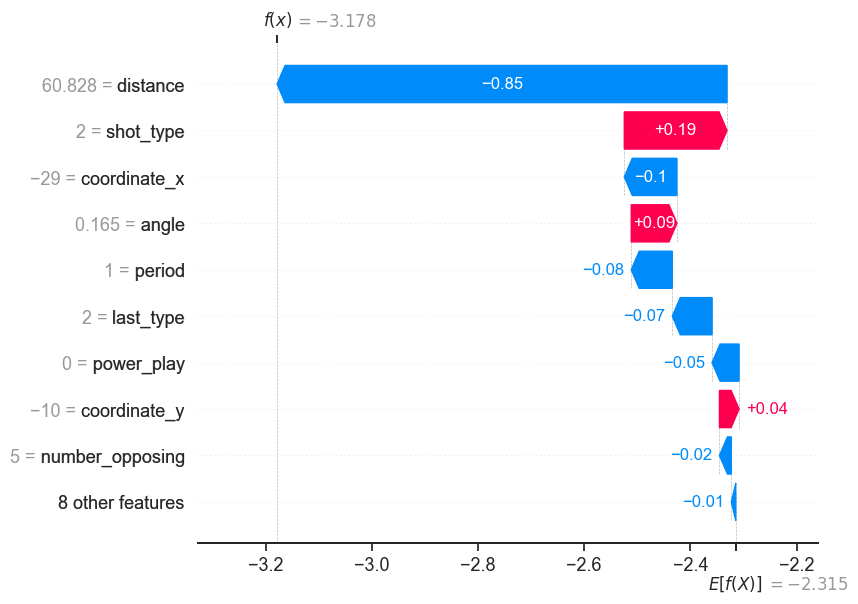

In [206]:
#use shap
explainer = shap.Explainer(model_2_best)
shap_values = explainer(X_train_2)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [57]:
#get the result with the best feature in SHAP
from matplotlib import pyplot
from pprint import pprint



X_train = X_train_2[['coordinate_x','shot_type','angle','distance']]
X_test = X_test_2[['coordinate_x','shot_type','angle','distance']]


model_sharp = XGBClassifier()
model_sharp.fit(X_train,y_train_2)
acc_ex_sharp, lr_auc_sharp, lr_fpr_sharp, lr_tpr_sharp, lr_probs_sharp = metrics(experiment_sharp, model_sharp, X_test, y_test_2, "XGB", "Sharp")

COMET WARNING: truncated string; too long: 'AUC Score XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)- Sharp '...
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.c

Validation Accuracy: 0.9066402199882793
ROC AUC:0.7237


COMET INFO:     confusion-matrix         : 1
COMET INFO:     curve                    : 1
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (549.86 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     model graph              : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 3 file(s), remaining 

In [58]:
df_prob_goals_sharp, x_sharp, y_sharp = plot_gr_perc(lr_probs_sharp, y_test_2)
x_partition_sharp, z_sharp = plot_partition_perc(df_prob_goals_sharp)

In [59]:
experiment_lasso = Experiment(
    api_key=COMET_API_KEY,
    project_name="ift-6758",
    workspace="ift-6758-2",
)
experiment_lasso.set_name('Question-5/XGB-LassoFeatureSelection')


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift-6758-2/ift-6758/36bc816f3b614feb84c1c87790b4261c



In [61]:
#LASSO
from sklearn import linear_model
from sklearn import feature_selection 

clf = linear_model.Lasso(alpha=0.1)
feature = feature_selection.SelectFromModel(estimator=clf,threshold="mean").fit(X_train_2,y_train_2)

feature_idx = feature.get_support()
feature_name = X_train_2.columns[feature_idx]

print(f'feature name is: {feature_name}')

X_train = X_train_2[feature_name]
X_test = X_test_2[feature_name]

#train with new feature

model_lasso = XGBClassifier()
model_lasso.fit(X_train,y_train_2)
acc_ex_lasso, lr_auc_lasso, lr_fpr_lasso, lr_tpr_lasso, lr_probs_lasso = metrics(experiment_lasso, model_lasso, X_test, y_test_2, "XGB", "Lasso")


feature name is: Index(['distance', 'time_from_last', 'power_play'], dtype='object')


COMET WARNING: truncated string; too long: 'AUC Score XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)- Lasso '...
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1


Validation Accuracy: 0.9066852995537124
ROC AUC:0.6993


COMET INFO:     url                   : https://www.comet.com/ift-6758-2/ift-6758/36bc816f3b614feb84c1c87790b4261c
COMET INFO:   Metrics:
COMET INFO:     AUC Score XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               [truncated] : 0.6993
COMET INFO:     validation accuracy XGB-Lasso                                                                        : 0.9066852995537124
COMET INFO:   Others:
COMET INFO:     Name : Question-5/XGB-LassoFeatureSelection
COMET INFO:   Parameters:
COMET INFO:     alpha                    : 0.1
COMET INFO:     begin_iteration          : 0
COMET INFO:     copy_X                   : True
COMET INFO:     end_iteration            : 99
COMET INFO:     estimator                : Lasso(alpha=0.1)
COMET INFO:     estimator__alpha         : 0.1
COMET INFO:     estimator__copy_X        : True
COMET INFO:     estimator__fit_intercept : True
COMET INFO:     estimator__max_iter      : 1000
COMET INFO:     estimator__normalize     : deprecated

In [62]:
df_prob_goals_lasso, x_lasso, y_lasso = plot_gr_perc(lr_probs_lasso, y_test_2)
x_partition_lasso, z_lasso = plot_partition_perc(df_prob_goals_lasso)

In [63]:
experiment_tree = Experiment(
    api_key=COMET_API_KEY,
    project_name="ift-6758",
    workspace="ift-6758-2",
)
experiment_tree.set_name('Question-5/XGB-TreeBasedFeatureSelection')


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift-6758-2/ift-6758/280b20e52b47417589647d213f45322b



In [64]:
#Tree-based feature selection
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train_2, y_train_2)
feature = feature_selection.SelectFromModel(estimator=clf,threshold="mean").fit(X_train_2,y_train_2)

feature_idx = feature.get_support()
feature_name = X_train_2.columns[feature_idx]

print(f'feature name is: {feature_name}')

X_train = X_train_2[feature_name]
X_test = X_test_2[feature_name]

#train with new feature

model_tree = XGBClassifier()
model_tree.fit(X_train,y_train_2)
acc_ex_tree, lr_auc_tree, lr_fpr_tree, lr_tpr_tree, lr_probs_tree = metrics(experiment_tree, model_tree, X_test, y_test_2, "XGB", "TreeFeatureSelection")

feature name is: Index(['coordinate_x', 'coordinate_y', 'distance', 'angle', 'last_coord_x',
       'last_coord_y', 'time_from_last', 'from_last_distance'],
      dtype='object')


COMET WARNING: truncated string; too long: 'AUC Score XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)- TreeFeatureSelection '...
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   

Validation Accuracy: 0.9065350343356023
ROC AUC:0.7147


COMET INFO:     feature_types                       : ['float', 'float', 'float', 'float', 'float', 'float', 'int', 'float']
COMET INFO:     importance_getter                   : auto
COMET INFO:     max_depth                           : 1
COMET INFO:     max_features                        : 4
COMET INFO:     max_leaf_nodes                      : 1
COMET INFO:     max_samples                         : 1
COMET INFO:     min_impurity_decrease               : 0.0
COMET INFO:     min_samples_leaf                    : 1
COMET INFO:     min_samples_split                   : 2
COMET INFO:     min_weight_fraction_leaf            : 0.0
COMET INFO:     n_estimators                        : 50
COMET INFO:     n_jobs                              : 1
COMET INFO:     norm_order                          : 1
COMET INFO:     objective                           : binary:logistic
COMET INFO:     oob_score                           : False
COMET INFO:     prefit                              : False
COMET

In [72]:
df_prob_goals_tree, x_tree, y_tree = plot_gr_perc(lr_probs_tree, y_test_2)
x_partition_tree, z_tree = plot_partition_perc(df_prob_goals_tree)

In [86]:
df_prob_goals_random, x_random, y_random = plot_gr_perc(ns_probs, y_test)
x_partition_random, z_random = plot_partition_perc(df_prob_goals_random)

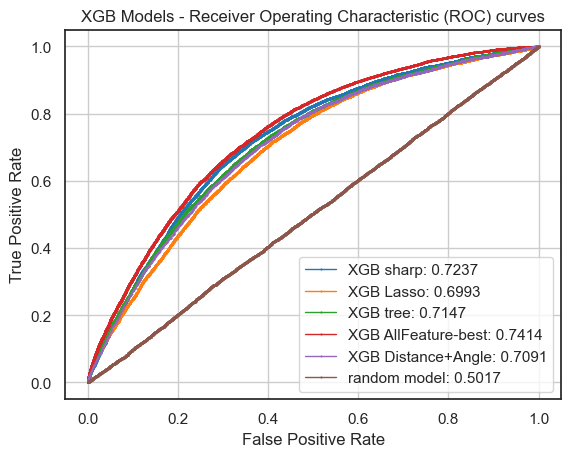

In [85]:
plt.plot(lr_fpr_sharp, lr_tpr_sharp, marker='.', linewidth=1, markersize=1,label=f"XGB sharp: {lr_auc_sharp}")
plt.plot(lr_fpr_lasso, lr_tpr_lasso, marker='.', linewidth=1, markersize=1,label=f"XGB Lasso: {lr_auc_lasso}")
plt.plot(lr_fpr_tree, lr_tpr_tree, marker='.', linewidth=1, markersize=1,label=f"XGB tree: {lr_auc_tree}")
plt.plot(lr_fpr_best, lr_tpr_best, marker='.', linewidth=1, markersize=1,label=f"XGB AllFeature-best: {lr_auc_best}")
plt.plot(lr_fpr_first, lr_tpr_first, marker='.', linewidth=1, markersize=1,label=f"XGB Distance+Angle: {lr_auc_first}")
plt.plot(ns_fpr, ns_tpr, marker='.', linewidth=1, markersize=1,label=f"random model: {ns_auc}")



plt.title('XGB Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
          

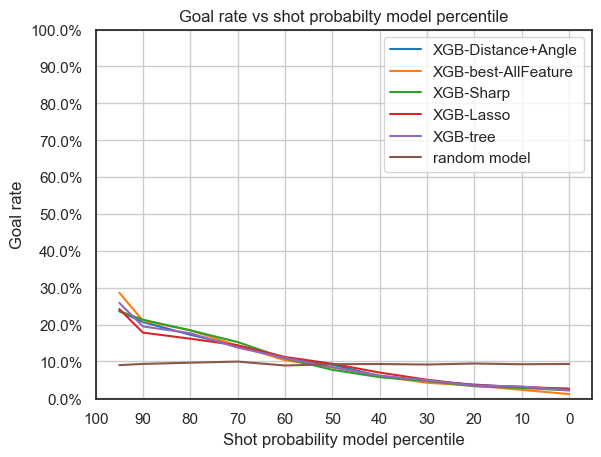

In [87]:
sns.set_theme(style="white", palette=None)
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_first['count'] / y_first['count']), label = f'XGB-Distance+Angle')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_second['count'] / y_second['count']), label = f'XGB-best-AllFeature')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_sharp['count'] / y_sharp['count']), label = f'XGB-Sharp')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_lasso['count'] / y_lasso['count']), label = f'XGB-Lasso')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_tree['count'] / y_tree['count']), label = f'XGB-tree')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_random['count'] / y_random['count']), label = f'random model')

plt.title('Goal rate vs shot probabilty model percentile')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Goal rate")
#ax.set_yscale('prob')
fmt = '%.1f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)
plt.gca().invert_xaxis()
plt.grid()
plt.xticks(np.arange(0, 101, 10.0))
plt.yticks(np.arange(0, 101, 10.0))
plt.show()

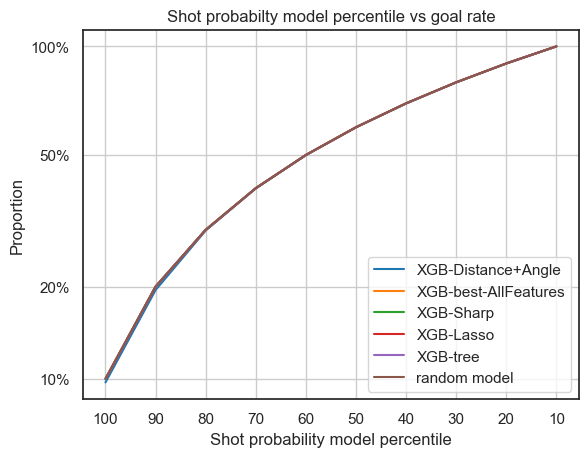

In [88]:
sns.set_theme(style="white", palette=None)
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_first['count']/z_first))).cumsum(), label = 'XGB-Distance+Angle')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_second['count']/z_second))).cumsum(), label = 'XGB-best-AllFeatures')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_sharp['count']/z_sharp))).cumsum(), label = 'XGB-Sharp')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_lasso['count']/z_lasso))).cumsum(), label = 'XGB-Lasso')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_tree['count']/z_tree))).cumsum(), label = 'XGB-tree')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_random['count']/z_random))).cumsum(), label = 'random model')


plt.title('Shot probabilty model percentile vs goal rate')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Proportion")
plt.yscale('prob')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid()
plt.show()

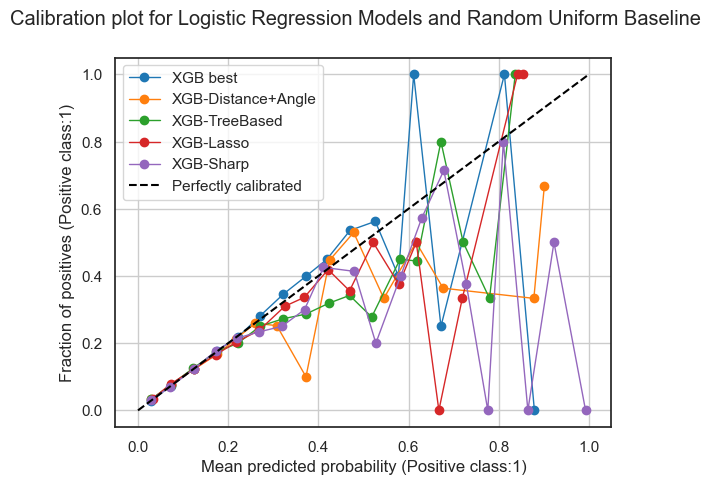

In [89]:
xgb_y_best, xgb_x_best = calibration_curve(y_test_2, lr_probs_best, n_bins=20)
xgb_y_1, xgb_x_1 = calibration_curve(y_test, lr_probs_first, n_bins=20)
xgb_y_tree, xgb_x_tree = calibration_curve(y_test_2, lr_probs_tree, n_bins=20)
xgb_y_sharp, xgb_x_sharp = calibration_curve(y_test_2, lr_probs_sharp, n_bins=20)
xgb_y_lasso, xgb_x_lasso = calibration_curve(y_test_2, lr_probs_lasso, n_bins=20)


fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(xgb_x_best,xgb_y_best, marker='o', linewidth=1, label='XGB best')
plt.plot(xgb_x_1,xgb_y_1, marker='o', linewidth=1, label='XGB-Distance+Angle')
plt.plot(xgb_x_tree,xgb_y_tree, marker='o', linewidth=1, label='XGB-TreeBased')
plt.plot(xgb_x_lasso,xgb_y_lasso, marker='o', linewidth=1, label='XGB-Lasso')
plt.plot(xgb_x_sharp,xgb_y_sharp, marker='o', linewidth=1, label='XGB-Sharp')

# reference line, legends, and axis labels
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
fig.suptitle('Calibration plot for Logistic Regression Models and Random Uniform Baseline')
ax.set_xlabel('Mean predicted probability (Positive class:1)')
ax.set_ylabel('Fraction of positives (Positive class:1)')
plt.grid()
plt.legend()
plt.show()

In [90]:
#log the best model
experiment_best_model = Experiment(
    api_key=COMET_API_KEY,
    project_name="ift-6758",
    workspace="ift-6758-2",
)
experiment_best_model.set_name('Question-5/LogBestModel')

model_tree.save_model('best_treebased.h5')
experiment_best_model.log_model('best_treebased.h5', 'best_treebased.h5', overwrite=True)
experiment_best_model.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift-6758-2/ift-6758/334e1ecf7b77415eb6c282705a7218d0

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift-6758-2/ift-6758/334e1ecf7b77415eb6c282705a7218d0
COMET INFO:   Others:
COMET INFO:     Name : Question-5/LogBestModel
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                